## 워킹캐글  Two Sigma Connect: Rental Listing Inquiries 
## 04/22일(토) 2회차 모임 - 이상열, 남기현, 김찬희, 유민규, 

### 1- Introduction
### 2- EDA
### 3- Modeling
### 4- To be...


### 1 - Introduction
- 새 집으로 전화 할 수있는 완벽한 장소를 찾는 일은 끝없는 목록을 탐색하는 것 이상이어야합니다. 
- RentHop은 데이터를 사용하여 임대 목록을 품질별로 분류하여 아파트 검색을 더 똑똑하게 만듭니다. 
- 그러나 완벽한 아파트를 찾기는 어렵지만 사용 가능한 모든 부동산 데이터를 프로그래밍 방식으로 구조화하고 이해하는 것이 더욱 어렵습니다. 
- Two Sigma Ventures의 포트폴리오 회사 ​​인 Sigma와 RentHop은이 독창적 인 모집 경쟁에서 비즈니스 가치를 창출하기 위해 Kagglers가 독창적 인 엔진을 발휘하도록 초대합니다.

- 2 시그마는 귀하가 RentHop의 렌탈리스트 데이터를 특징으로하는이 모집 경쟁에서 자신의 재능을 적용하도록 권유합니다. 
- Kagglers는 목록의 생성 날짜 및 기타 기능을 기반으로 새로운 목록이받는 문의 건수를 예측합니다. 
- 이렇게하면 RentHop이 사기 관리를보다 잘 처리하고 잠재적 인 리스팅 품질 문제를 식별하며 소유자와 대행사가 임차인의 필요와 선호도를보다 잘 이해할 수 있습니다.

- 두 시그마는 재무 예측에 기술 및 데이터 과학을 적용하는 최전선에 서 있습니다. 
- 금융 세계에서 빅 데이터, 인공 지능 및 기계 학습에 대한 선구자적인 발전은 다른 모든 과학적 진보와 마찬가지로 업계를 선도적으로 추진해 왔지만 계속해서 진전을 이루어 냈습니다. 
- 이 도전은 경쟁자가 Two Sigma의 금융 외부 데이터 과학 작품을 들여다 볼 수있는 기회입니다.

<img src ='https://kaggle2.blob.core.windows.net/competitions/kaggle/5590/media/twosigma-renthop-banner-250x250.png'>

- Submissions are evaluated using the multi-class logarithmic loss. Each listing has one true class. For each listing, you must submit a set of predicted probabilities oneforeverylistingoneforeverylisting. The formula is then,


$$
log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})
$$

### 2 - EDA

In [23]:
#라이브러리 로딩
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set(style='ticks')
color = sns.color_palette()

import thinkstats2, thinkplot # Do "pip install thinkx", if necessary

%matplotlib inline

In [5]:
train_df = pd.read_json("./data/train.json")

## data description

In [6]:
train_df.iloc[2][['bathrooms', 'bedrooms', 'listing_id', 'building_id', 'manager_id',
                  'created', 'latitude', 'longitude', 'price', 'display_address', 'street_address',
                  'description', 'features', 'photos', 'interest_level']]

bathrooms                                                          1
bedrooms                                                           1
listing_id                                                   6887163
building_id                         c3ba40552e2120b0acfc3cb5730bb2aa
manager_id                          d9039c43983f6e564b1482b273bd7b01
created                                          2016-04-17 03:26:41
latitude                                                     40.7388
longitude                                                   -74.0018
price                                                           2850
display_address                                          W 13 Street
street_address                                       241 W 13 Street
description        Top Top West Village location, beautiful Pre-w...
features           [Laundry In Building, Dishwasher, Hardwood Flo...
photos             [https://photos.renthop.com/2/6887163_de85c427...
interest_level                    

- bathrooms: number of bathrooms
- bedrooms: number of bathrooms
- listing_id: 포스팅 ID
- building_id: 건물 ID
- manager_id: 포스팅 게시자 ID
- created: 포스팅 된 시각 (UTC 기준으로 생각됨)
- latitude: 위도
- longitude: 경도
- price: in USD
    
- display_address: 주소 (도로명까지)
- street_address: 주소 (번지까지)

In [7]:
train_df.iloc[2][['display_address', 'street_address']]

display_address        W 13 Street
street_address     241 W 13 Street
Name: 100004, dtype: object

- description: 게시자의 소개글
- features: a list of features about this apartment

In [8]:
train_df.iloc[2]['description']

'Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and conveniently located near A,C,E,L,1,2,3 trains. Surrounded by many local cafe?s, restaurants, available for November 1st move in!<br/><br/>To view this apartment or any other please contact me via email or call at the number listed.<br/><br/><br/><br/><br/><br/>Bond New York is a real estate broker that supports equal housing opportunity.<p><a  website_redacted '

In [9]:
train_df.iloc[2]['features']

['Laundry In Building',
 'Dishwasher',
 'Hardwood Floors',
 'Pets Allowed Case by Case']

In [10]:
train_df.iloc[2]['photos']

['https://photos.renthop.com/2/6887163_de85c427363a2e6d736a5df96d8d5541.jpg',
 'https://photos.renthop.com/2/6887163_b9cf6db6df611bc53f75be3214a43807.jpg',
 'https://photos.renthop.com/2/6887163_cd3f2246cfd25691f33ed12b251d0230.jpg',
 'https://photos.renthop.com/2/6887163_54c402cf0d681f6ea4796b9d177786bb.jpg',
 'https://photos.renthop.com/2/6887163_7745da2a3693fe627154794ab0ebca29.jpg',
 'https://photos.renthop.com/2/6887163_95c93e4af27182f8ac55c749fc74a041.jpg',
 'https://photos.renthop.com/2/6887163_4b50a743b760e23b8d6f6f586a704da7.jpg',
 'https://photos.renthop.com/2/6887163_6133523d6d5a0fba36bb25e3616848c8.jpg']

In [11]:
train_df['interest_level'].head().tolist()

['medium', 'low', 'high', 'low', 'low']

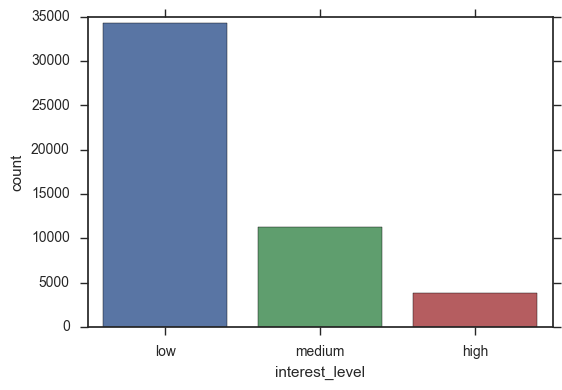

In [12]:
sns.countplot(x='interest_level', data=train_df, order=['low', 'medium', 'high'])
plt.show()

- interest_level은 대부분 low이고, high는 가장 적다.
- 모델 학습할 때 클래스 간의 비율을 1:1:1로 맞추기 위해 oversampling/undersampling 필요.

## price

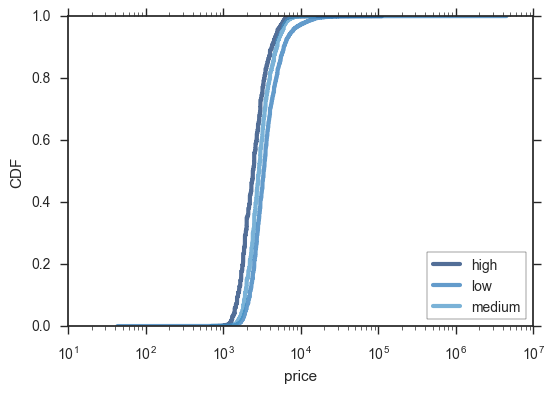

In [13]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['price'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='price', ylabel='CDF', xscale='log')

- 가격이 저렴할 수록 interest level이 높다.

## bathrooms

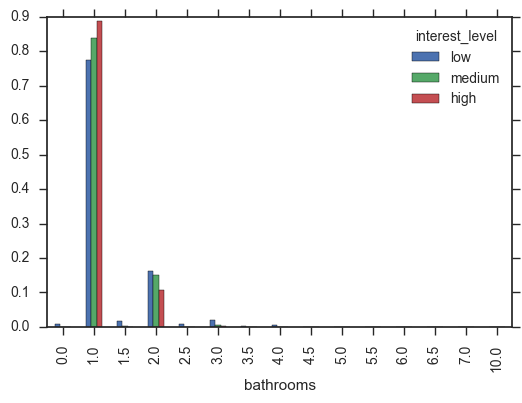

In [14]:
bathrooms = train_df.groupby(['bathrooms', 'interest_level'])['bathrooms'].count().unstack('interest_level')
bathrooms /= bathrooms.sum()
bathrooms[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 화장실은 대체로 1개이고, 침실은 0-2개인 경우가 많다.
- 화장실이 1개일 때 상대적으로 high일 가능성이 크고, 화장실이 2개일 때는 high일 가능성이 적다. 나머지 경우 low일 가능성이 크다.

## bedrooms

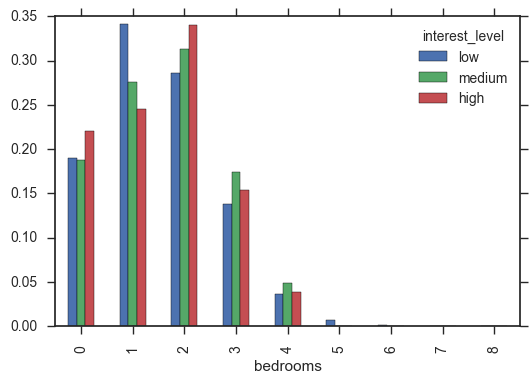

In [15]:
bedrooms = train_df.groupby(['bedrooms', 'interest_level'])['bedrooms'].count().unstack('interest_level')
bedrooms /= bedrooms.sum()
bedrooms[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 침실이 0, 2개일 때 high일 가능성이 크다.
- 침실이 1개일 때, 그리고 5개 이상일 때 low일 가능성이 크다.
- 침실이 3, 4개일 때 medium일 가능성이 크다.

## created

In [16]:
train_df['created'] = pd.to_datetime(train_df['created'])
train_df['week'] = train_df['created'].dt.week
# train_df['hour'] = train_df['created'].dt.hour
train_df['hour'] = (train_df['created'].dt.hour - 5) % 24 # 동부 표준시는 UTC-05:00 이다.
train_df['weekday'] = train_df['created'].dt.weekday

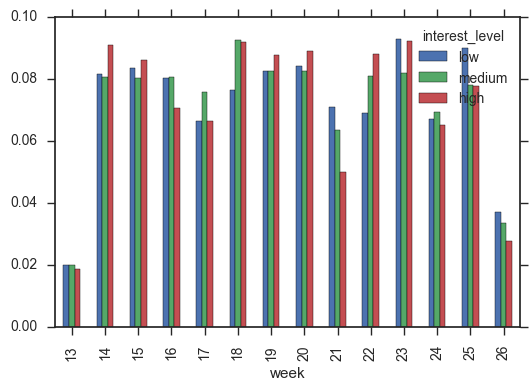

In [17]:
weeks = train_df.groupby(['week', 'interest_level'])['week'].count().unstack('interest_level')
weeks /= weeks.sum()
weeks[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 주별로 차이가 있지만 그 차이가 미미하다.

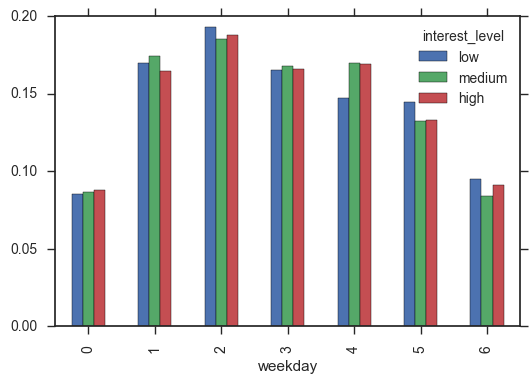

In [18]:
weekdays = train_df.groupby(['weekday', 'interest_level'])['weekday'].count().unstack('interest_level')
weekdays /= weekdays.sum()
weekdays[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- weekday가 0이면 월요일, 1이면 화요일, ..., 6이면 일요일이다.

- 요일에 대한 분포에는 약간의 차이는 있지만 미미하다.

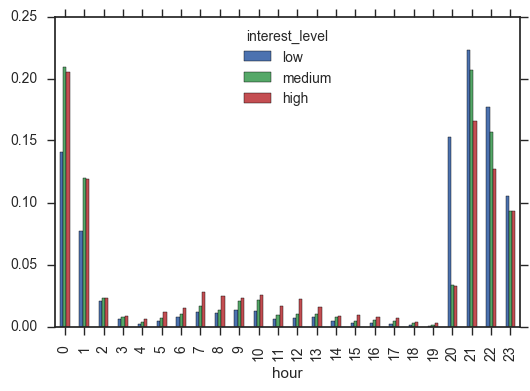

In [19]:
hours = train_df.groupby(['hour', 'interest_level'])['hour'].count().unstack('interest_level').fillna(0)
hours /= hours.sum()
hours[['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 시간에 대한 분포에 차이가 있음. 
- 20-23시, 특히 20시에 게시된 글은 low일 가능성이 높다. 낮에 게시된 글은 high일 가능성이 높다.

## photos, features & descriptions

In [20]:
train_df.loc[:, 'num_photos'] = train_df.loc[:, 'photos'].apply(len)
train_df.loc[:, 'num_features'] = train_df.loc[:, 'features'].apply(len)
train_df.loc[:, 'num_words'] = train_df.loc[:, 'description'].apply(lambda x: len(x.split(' ')))

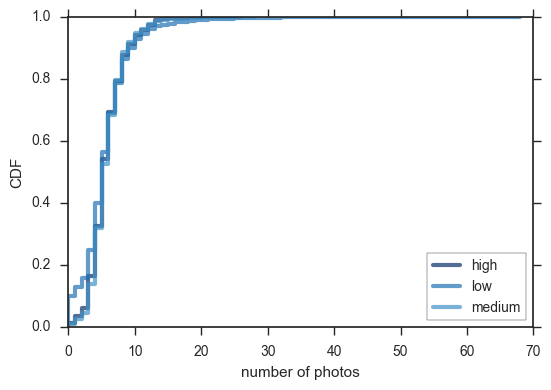

In [21]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_photos'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of photos', ylabel='CDF')

- 세 분포가 사진이 10개 이하일 때 차이가 있다.

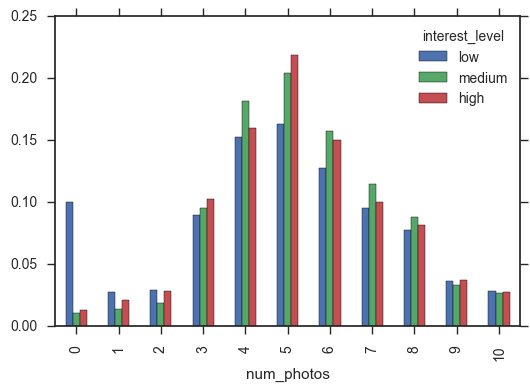

In [22]:
photos = train_df.groupby(['num_photos', 'interest_level'])['num_photos'].count().unstack('interest_level').fillna(0)
photos /= photos.sum()
photos.ix[:10, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 사진이 0개이면 low일 가능성이 아주 크고, 4-8개이면 low일 가능성이 적다. 특히, 5개일 때 high일 가능성이 아주 높다.

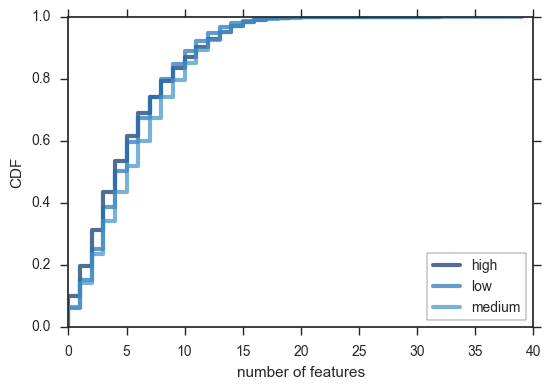

In [24]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_features'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of features', ylabel='CDF')

- 세 분포가 특징이 15개 이하일 때 차이가 있다.

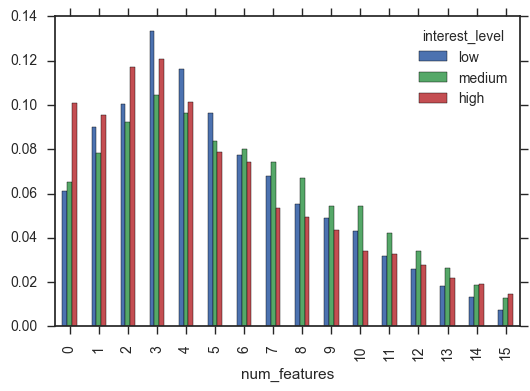

In [25]:
features = train_df.groupby(['num_features', 'interest_level'])['num_features'].count().unstack('interest_level').fillna(0)
features /= features.sum()
features.ix[:15, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 대체로 특징이 적을 때, 0-2개일 때 high일 가능성이 크다.
- 특징이 3-5개일 때 low일 가능성이 크다.
- 특징이 6개 이상이면 medium일 가능성이 크다.

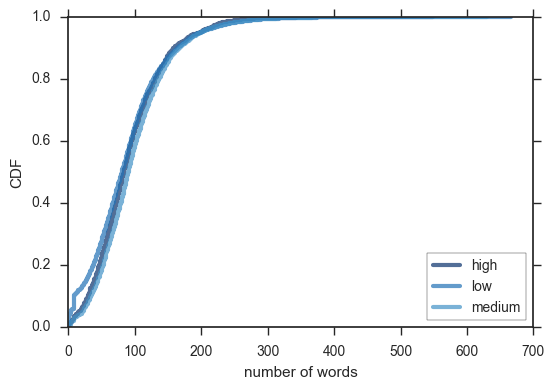

In [26]:
for l, g in train_df.groupby('interest_level'):
    cdf = thinkstats2.Cdf(g['num_words'], label=l)
    thinkplot.Cdf(cdf)
thinkplot.Show(loc='lower right', xlabel='number of words', ylabel='CDF')

- 세 분포가 거의 일치. 개수가 아주 적을 때 약간의 차이가 있다.

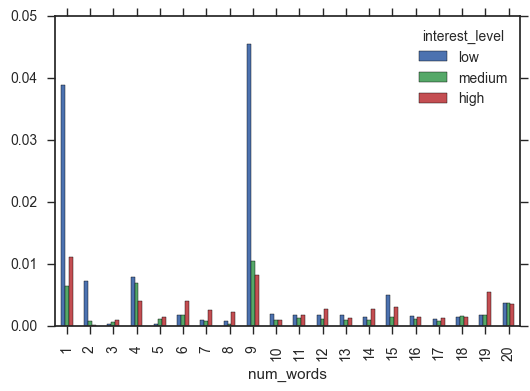

In [29]:
words = train_df.groupby(['num_words', 'interest_level'])['num_words'].count().unstack('interest_level').fillna(0)
words /= words.sum()
words.ix[:20, ['low', 'medium', 'high']].plot(kind='bar')
plt.show()

- 개수가 1, 9개일 때 low일 가능성이 아주 크나, 그외의 경우 차이가 미미하다.

In [32]:
### Quantitative substitute of Interest Level
train_df['interest'] = np.where(train_df.interest_level=='low', 0,
                                  np.where(train_df.interest_level=='medium', 1, 2))

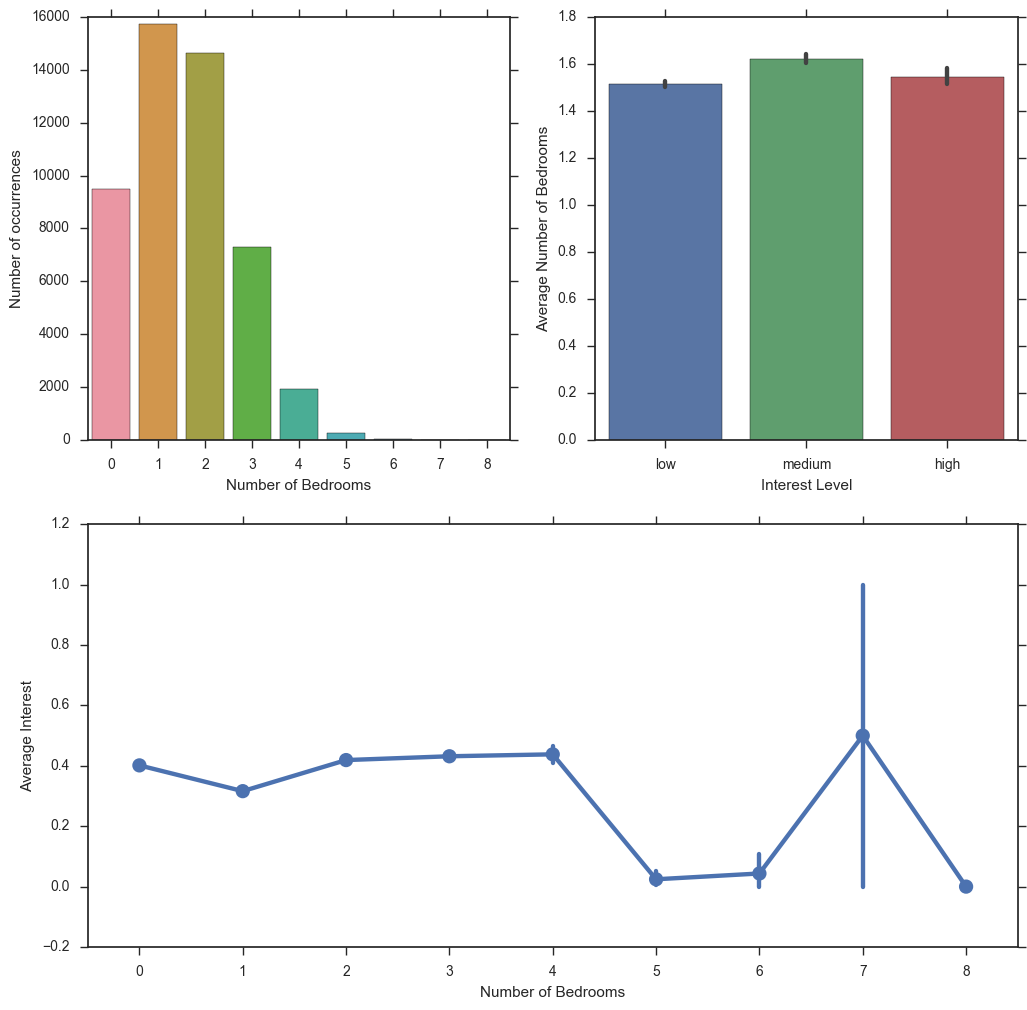

In [33]:
### Bedrooms graphs
fig = plt.figure(figsize=(12,12))
### Number of occurrences
sns.countplot(train_df.bedrooms, ax = plt.subplot(221));
plt.xlabel('Number of Bedrooms');
plt.ylabel('Number of occurrences');
### Average number of Bedrooms per Interest Level
sns.barplot(x='interest_level', y='bedrooms', data=train_df, order=['low', 'medium', 'high'],
            ax = plt.subplot(222));
plt.xlabel('Interest Level');
plt.ylabel('Average Number of Bedrooms');
### Average interest for every number of bedrooms
sns.pointplot(x="bedrooms", y="interest", data=train_df, ax = plt.subplot(212));
plt.xlabel('Number of Bedrooms');
plt.ylabel('Average Interest');

In [36]:
### Most advertised buildings
train_df.building_id.value_counts().nlargest(10)

0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
f68bf347f99df026f4faad43cc604048     191
c94301249b8c09429d329864d58e5b82     167
ce6d18bf3238e668b2bf23f4110b7b67     165
57ef86c28a8ae482dc3a3c3af28e8e48     159
128d4af0683efc5e1eded8dc8044d5e3     153
Name: building_id, dtype: int64

In [37]:
### Convertion to Python Date
train_df.created = pd.to_datetime(train_df.created, format='%Y-%m-%d %H:%M:%S')

In [38]:
train_df.created = pd.to_datetime(train_df.created, format='%Y-%m-%d %H:%M:%S')

### New Month, Day of Week and Hour Features
train_df['month'] = train_df.created.dt.month
train_df['day_of_week'] = train_df.created.dt.weekday_name
train_df['hour'] = train_df.created.dt.hour

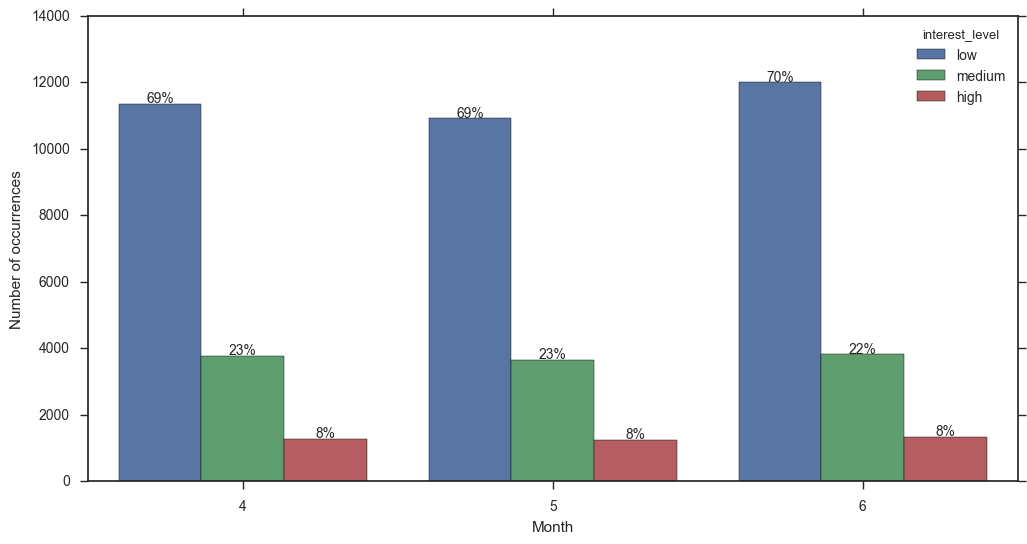

In [39]:
### Iterest per month
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(x="month", hue="interest_level", hue_order=['low', 'medium', 'high'],
                   data=train_df);
plt.xlabel('Month');
plt.ylabel('Number of occurrences')

### Adding prcents over bars
height = [p.get_height() for p in ax.patches]
ncol = int(len(height)/3)
total = [height[i] + height[i + ncol] + height[i + 2*ncol] for i in range(ncol)] * 3
for i, p in enumerate(ax.patches):    
    ax.text(p.get_x()+p.get_width()/2,
            height[i] + 50,
            '{:1.0%}'.format(height[i]/total[i]),
            ha="center") 

In [40]:
### 15 most popular Display Addresses
train_df.display_address.value_counts().nlargest(15)

Broadway             438
East 34th Street     355
Second Avenue        349
Wall Street          332
West 37th Street     287
West Street          258
First Avenue         244
Gold Street          241
Washington Street    237
York Avenue          228
John Street          214
Water Street         214
East 39th Street     200
East 89th Street     195
West 54th Street     193
Name: display_address, dtype: int64

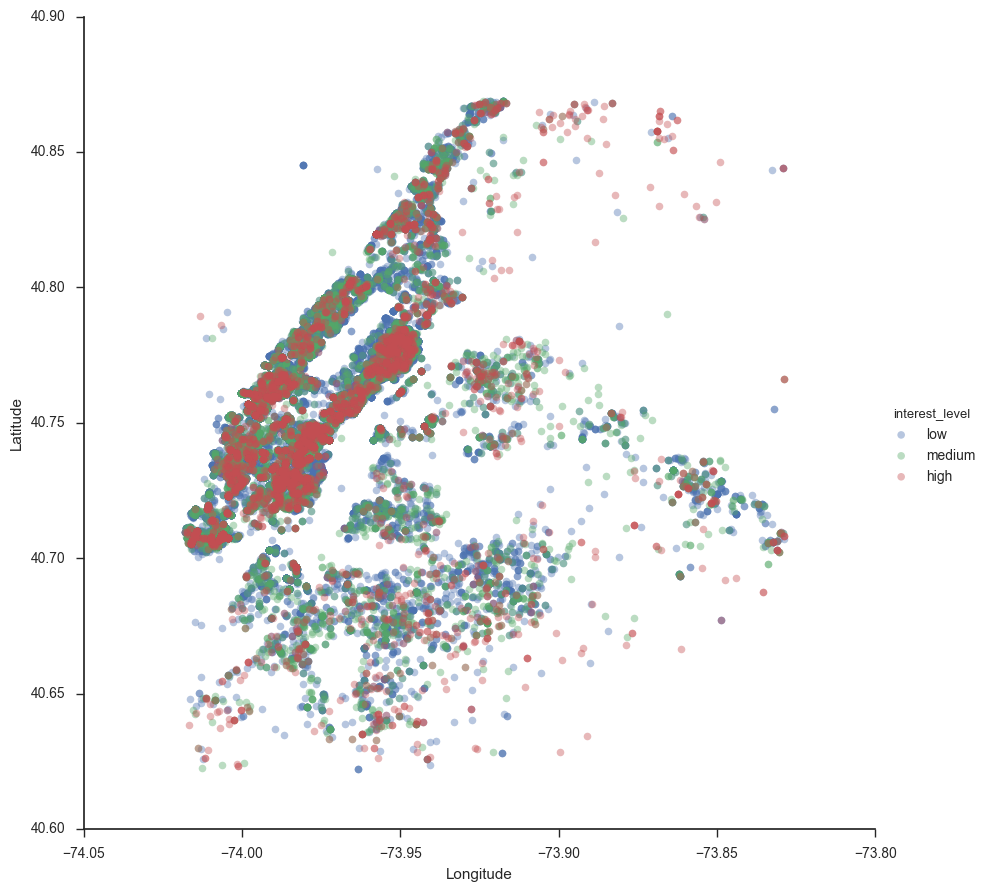

In [41]:
### Rent interest graph of New-York
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train_df[(train_df.longitude>train_df.longitude.quantile(0.005))
                           &(train_df.longitude<train_df.longitude.quantile(0.995))
                           &(train_df.latitude>train_df.latitude.quantile(0.005))                           
                           &(train_df.latitude<train_df.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');

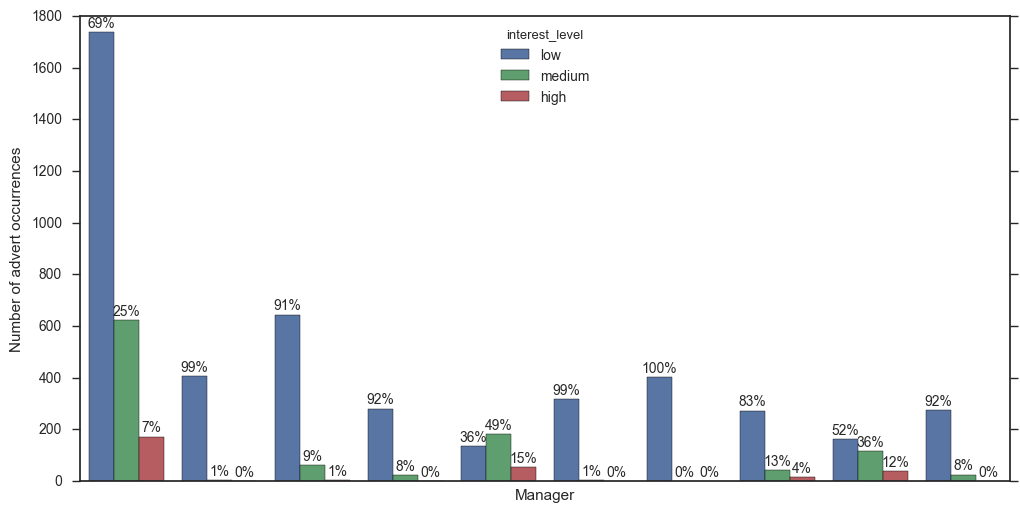

In [42]:
### Let's get a list of top 10 managers
top10managers = train_df.manager_id.value_counts().nlargest(10).index.tolist()
### ...and plot number of different Interest Level rental adverts for each of them
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(x="manager_id", hue="interest_level",
                   data=train_df[train_df.manager_id.isin(top10managers)]);
plt.xlabel('Manager');
plt.ylabel('Number of advert occurrences');
### Manager_ids are too long. Let's remove them
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off');

### Adding percents over bars
height = [0 if np.isnan(p.get_height()) else p.get_height() for p in ax.patches]
ncol = int(len(height)/3)
total = [height[i] + height[i + ncol] + height[i + 2*ncol] for i in range(ncol)] * 3
for i, p in enumerate(ax.patches):    
    ax.text(p.get_x()+p.get_width()/2,
            height[i] + 20,
            '{:1.0%}'.format(height[i]/total[i]),
            ha="center")

In [43]:
### Getting number of photos
train_df['photos_number'] = train_df.photos.str.len()

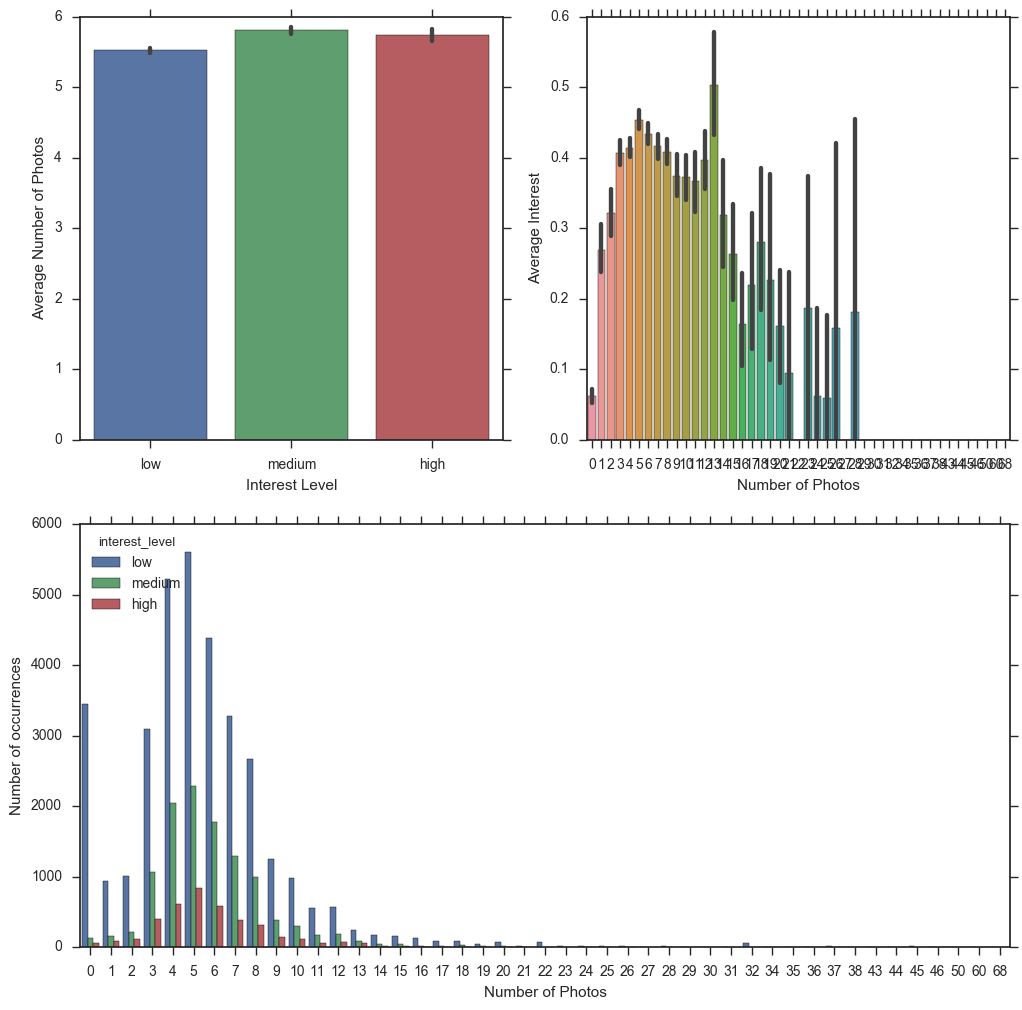

In [44]:
### Number of photos graphs
fig = plt.figure(figsize=(12,12))
### Average number of Photos per Interest Level
sns.barplot(x="interest_level", y="photos_number", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(221));
plt.xlabel('Interest Level');
plt.ylabel('Average Number of Photos');
### Average interest for every number of photos
sns.barplot(x="photos_number", y="interest", data=train_df, ax=plt.subplot(222));
plt.xlabel('Number of Photos');
plt.ylabel('Average Interest');
### Number of occurrences
sns.countplot(x='photos_number', hue='interest_level', hue_order=['low', 'medium', 'high'],
              data=train_df, ax=plt.subplot(212));
plt.xlabel('Number of Photos');
plt.ylabel('Number of occurrences');

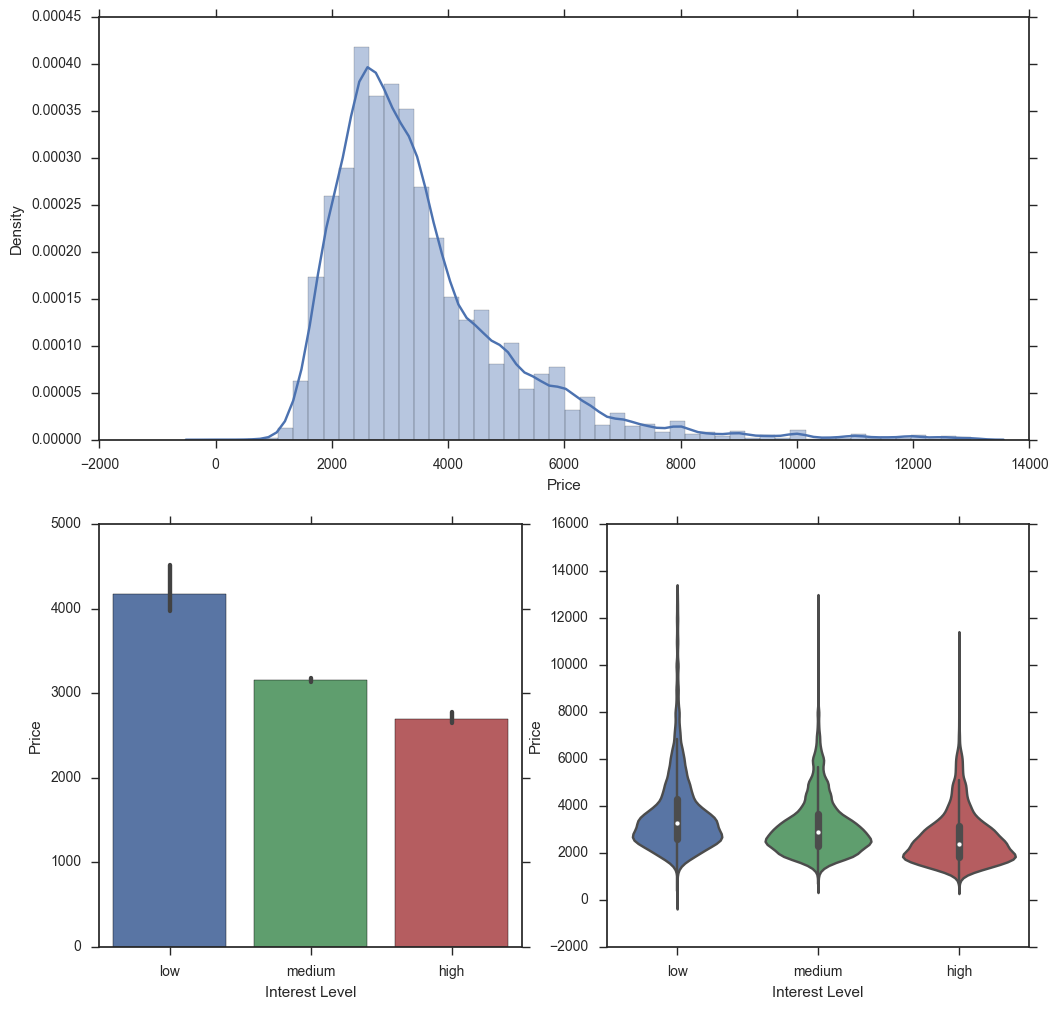

In [46]:
### Price exploration
fig = plt.figure(figsize=(12,12))
### Price distribution
sns.distplot(train_df.price[train_df.price<=train_df.price.quantile(0.99)], ax=plt.subplot(211));
plt.xlabel('Price');
plt.ylabel('Density');
### Average Price per Interest Level
sns.barplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(223));
plt.xlabel('Interest Level');
plt.ylabel('Price');
### Violinplot of price for every Interest Level
sns.violinplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
               data=train_df[train_df.price<=train_df.price.quantile(0.99)],
               ax=plt.subplot(224));
plt.xlabel('Interest Level');
plt.ylabel('Price');

## 3- Modeling

In [2]:
#input data
train_df=pd.read_json('./data/train.json')
test_df=pd.read_json('./data/test.json')

In [4]:
#basic features
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))


# 원래 있던 original값들과 새로만든 feature를 넣어 feature_to_use 리스트 만듬
features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]

In [5]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,price_t,room_sum,num_photos,num_features,num_description_words
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1000.0,4.5,5,0,95
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,2732.5,3.0,11,5,9
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,2850.0,2.0,8,4,94
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,3275.0,2.0,3,2,80
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,837.5,5.0,3,1,68


In [6]:
#https://flonelin.wordpress.com/2016/07/26/tuning-xgboostextream-gradient-boosting/
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.03
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7 # 70프로만 뽑겠다
    param['colsample_bytree'] = 0.7 # 컬럼의 ratio 최대 몇개만 쓰겠다라는 의미?
    param['seed'] = seed_val # 초기값 설정 랜덤 안되게
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y) # D매트릭스로 바꿔줘야 한다.

    # test의 타겟값을 넣은 xgb model
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    # test의 타겟값을 넣지 않은 xgb model
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [7]:
# train data 의 수만큼의 list를 만듬
index=list(range(train_df.shape[0]))
random.shuffle(index) # 값 셔플
a=[np.nan]*len(train_df) # 데이터 수만큼 리스트 만들고
b=[np.nan]*len(train_df)
c=[np.nan]*len(train_df)

In [8]:
# 데이터를 5등분할 계획
# 매니저id를 key로 하는 building_level을 만듦
for i in range(5): 
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c

In [9]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,price,street_address,price_t,room_sum,num_photos,num_features,num_description_words,manager_level_low,manager_level_medium,manager_level_high
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,3000,792 Metropolitan Avenue,1000.0,4.5,5,0,95,0.746835,0.253165,0.000000
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,5465,808 Columbus Avenue,2732.5,3.0,11,5,9,0.985075,0.014925,0.000000
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,2850,241 W 13 Street,2850.0,2.0,8,4,94,0.558559,0.387387,0.054054
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,3275,333 East 49th Street,3275.0,2.0,3,2,80,0.806897,0.137931,0.055172
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,3350,500 West 143rd Street,837.5,5.0,3,1,68,1.000000,0.000000,0.000000


In [10]:
# 이번엔 train데이터를 통해 집계한 매니저에 대한 'interest level별 count정보'로 test데이터의 'manager에 대한 interest level별 비율정보'을 구함
a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]
for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

In [11]:
building_level

{'3813434aabfbad659a45f86a740cd23f': [18, 0, 0],
 'ade2447840ae8506ffef0f51144026a6': [1, 0, 0],
 '4ca42a79f4e7c69153c2898ab650cc95': [0, 1, 1],
 'c5bbbe437129949e2b761f01564180d5': [0, 1, 0],
 '3b89bc3fb0ec629d0d08b46e1ecaaf7e': [1, 0, 0],
 'c0f3d0ebec839a79dc91bc84cc9abac3': [1, 0, 0],
 '6e549a6ae3658c8e0cd0b0614570ed8d': [1, 0, 0],
 '525dab2c0e34bc398181143e4cfa5dcc': [12, 0, 0],
 'b4fdeb6b39e69fed571c88c8fc9f08ee': [0, 0, 1],
 '24e99d9e08a0529de08e8aa192980730': [0, 3, 0],
 '94e87282640f0a3bd6835ce386618a55': [25, 0, 0],
 '456089ec27510652ee3878a399ed56e0': [1, 0, 1],
 'cca9105ab4989fe60d622922e0ec8dd3': [2, 0, 0],
 'd959561ac12b0410f139756a3234db9a': [35, 3, 0],
 'efd6b3aceddb359eb13bbd2e7eeae9ee': [1, 0, 0],
 '7bf4502f383da71e9e7a73233284f9f1': [1, 0, 0],
 'c5a5de5dc6c510af70aa6a5d491c4e35': [0, 0, 1],
 'b1b1852c416d78d7765d746cb1b8921f': [11, 8, 5],
 '27c01d28635ee97b9c3cf1ffb1033826': [2, 0, 0],
 'b13ea807042d4e1fe8f4c23b868efe0d': [1, 0, 0],
 '614e9c02bcb1b7feaff502d4c1203c47'

In [12]:
test_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,price,street_address,price_t,room_sum,num_photos,num_features,num_description_words,manager_level_low,manager_level_medium,manager_level_high
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,...,2950,99 Suffolk Street,2950.0,2.0,8,6,78,0.458333,0.333333,0.208333
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,...,2850,176 Thompson Street,1425.0,3.0,3,3,35,1.000000,0.000000,0.000000
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,...,3758,101 East 10th Street,3758.0,2.0,6,3,333,0.000000,1.000000,0.000000
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,...,3300,251 South Third Street\r,1650.0,3.0,6,10,204,0.245902,0.393443,0.360656
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,...,4900,260 West 54th Street,2450.0,4.0,7,14,174,0.597222,0.319444,0.083333


In [13]:
#위에서 애써만든 매니저 평가정보를 여기에서 feature에 포함시킴
features_to_use.append('manager_level_low') 
features_to_use.append('manager_level_medium') 
features_to_use.append('manager_level_high')

In [14]:
features_to_use

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'price_t',
 'num_photos',
 'num_features',
 'num_description_words',
 'listing_id',
 'manager_level_low',
 'manager_level_medium',
 'manager_level_high']

In [21]:
# 범주형 데이터를 넣는 과정
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder() #범주형 변수를 사용하기 위해 팩터화시키는것
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [22]:
train_df[['display_address','manager_id','building_id','street_address']]

,display_address,manager_id,building_id,street_address
10,12282,1568,3797,23484
10000,9080,1988,8986,23680
100004,13719,3733,8889,9827
100007,10866,282,1848,14237
100013,15072,2618,0,19227
100014,15194,3081,2544,15263
100016,14964,12,2711,7466
100020,15223,3959,169,4181
100026,11646,3339,7635,21836
100027,6459,633,0,20000


In [23]:
features_to_use

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'price_t',
 'num_photos',
 'num_features',
 'num_description_words',
 'listing_id',
 'manager_level_low',
 'manager_level_medium',
 'manager_level_high',
 'display_address',
 'manager_id',
 'building_id',
 'street_address']

In [24]:
train_df[f].values

array([23484, 23680,  9827, ..., 14787, 15771, 11802])

In [19]:
test_df[f].values

array([24898,  5492,   541, ..., 15281, 14244, 24425])

In [26]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,price,street_address,price_t,room_sum,num_photos,num_features,num_description_words,manager_level_low,manager_level_medium,manager_level_high
10,1.5,3,3797,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,12282,[],medium,40.7145,7211212,...,3000,23484,1000.0,4.5,5,0,95,0.746835,0.253165,0.000000
10000,1.0,2,8986,2016-06-12 12:19:27,,9080,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,5465,23680,2732.5,3.0,11,5,9,0.985075,0.014925,0.000000
100004,1.0,1,8889,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",13719,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,2850,9827,2850.0,2.0,8,4,94,0.558559,0.387387,0.054054
100007,1.0,1,1848,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,10866,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,3275,14237,3275.0,2.0,3,2,80,0.806897,0.137931,0.055172
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,15072,[Pre-War],low,40.8241,6934781,...,3350,19227,837.5,5.0,3,1,68,1.000000,0.000000,0.000000


In [27]:
len(features_to_use)

17

In [28]:
# original데이터의 features컬럼을 tfidf 팩터화
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [29]:
# xgb에 넣기위해 자료구조를 만듬
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 217) (74659, 217)


In [30]:
print(train_X)

  (0, 0)	1.5
  (0, 1)	3.0
  (0, 2)	40.7145
  (0, 3)	-73.9425
  (0, 4)	3000.0
  (0, 5)	1000.0
  (0, 6)	5.0
  (0, 8)	95.0
  (0, 9)	7211212.0
  (0, 10)	0.746835443038
  (0, 11)	0.253164556962
  (0, 13)	12282.0
  (0, 14)	1568.0
  (0, 15)	3797.0
  (0, 16)	23484.0
  (1, 0)	1.0
  (1, 1)	2.0
  (1, 2)	40.7947
  (1, 3)	-73.9667
  (1, 4)	5465.0
  (1, 5)	2732.5
  (1, 6)	11.0
  (1, 7)	5.0
  (1, 8)	9.0
  (1, 9)	7150865.0
  :	:
  (49350, 14)	2745.0
  (49350, 15)	7877.0
  (49350, 16)	15771.0
  (49350, 49)	1.0
  (49350, 70)	1.0
  (49350, 71)	1.0
  (49350, 78)	1.0
  (49350, 155)	1.0
  (49350, 209)	1.0
  (49351, 0)	1.0
  (49351, 1)	2.0
  (49351, 2)	40.8699
  (49351, 3)	-73.9172
  (49351, 4)	2200.0
  (49351, 5)	1100.0
  (49351, 6)	7.0
  (49351, 7)	1.0
  (49351, 8)	133.0
  (49351, 9)	6858245.0
  (49351, 10)	1.0
  (49351, 13)	12707.0
  (49351, 14)	3713.0
  (49351, 15)	3669.0
  (49351, 16)	11802.0
  (49351, 97)	1.0


In [18]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.08031	test-mlogloss:1.08078
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.06238	test-mlogloss:1.06329
[2]	train-mlogloss:1.04433	test-mlogloss:1.0457
[3]	train-mlogloss:1.02631	test-mlogloss:1.02822
[4]	train-mlogloss:1.01083	test-mlogloss:1.01317
[5]	train-mlogloss:0.99448	test-mlogloss:0.997322
[6]	train-mlogloss:0.980821	test-mlogloss:0.983998
[7]	train-mlogloss:0.966726	test-mlogloss:0.970186
[8]	train-mlogloss:0.952343	test-mlogloss:0.956265
[9]	train-mlogloss:0.938507	test-mlogloss:0.942816
[10]	train-mlogloss:0.926505	test-mlogloss:0.931154
[11]	train-mlogloss:0.915301	test-mlogloss:0.920341
[12]	train-mlogloss:0.904274	test-mlogloss:0.909722
[13]	train-mlogloss:0.894207	test-mlogloss:0.899952
[14]	train-mlogloss:0.883065	test-mlogloss:0.889089
[15]	train-mlogloss:0.872328	test-mlogloss:0.878781
[16]	train-mlogloss:0.862826	test-mlogl

In [89]:
cv_scores

[0.53731280004500748]

In [58]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=1000)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter2.csv", index=False)

## 3- Modeling

### Sklearn Basic Neural Network (0.583 LB)

- In the following network I build a NN based on the Sklearn interface. This is a brief summary of the steps I follow to build it:
    - Load data
    - Generate location features
    - Feature engineering ('basic_preprocess' function)
    - Normalize features
    - GridSearch on NN parametes to find the optimum
    - Generate predictions on the test dataset

- The generated predictions got a 0.584 log-loss (LB).
- Some of the feature engineering here is based on two previous notebooks:
    - Unsupervised and supervised neighborhood encoding
    - Price/Bedrooms/Bathrooms
- Any feedback or comment will be appreciated! Upvote if you found it interesting/useful :) Thanks!

In [49]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time as time
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline

In [50]:
def get_skf_indexes(df, target, kfold=4):
    X = df.values
    y = df[target].values
    skf = StratifiedKFold(n_splits=4);
    skf.get_n_splits(X, y);
    indexes = [[],[]]
    for train_index, test_index in skf.split(X, y):
        indexes[0].append(train_index)
        indexes[1].append(test_index)
    return indexes

In [51]:
def output_results(clf, x_test, listing, fname):
    preds = clf.predict_proba(x_test)
    preds = pd.DataFrame(preds)
    cols = ['low', 'medium', 'high']
    preds.columns = cols
    preds['listing_id'] = listing
    preds.to_csv(fname, index=None)
    print(preds[cols].mean().values)


def basic_preprocess(df_train, df_test, n_min=50, precision=3):
    
    # Interest: Numerical encoding of interest level
    df_train['y'] = 0.0
    df_train.loc[df_train.interest_level=='medium', 'y'] = 1.0
    df_train.loc[df_train.interest_level=='high', 'y'] = 2.0
    
    # Location features: Latitude, longitude
    df_train['num_latitude'] = df_train.latitude.values
    df_test['num_latitude'] = df_test.latitude.values
    df_train['num_longitude'] = df_train.longitude.values
    df_test['num_longitude'] = df_test.longitude.values
    x = np.sqrt(((df_train.latitude - df_train.latitude.median())**2) + (df_train.longitude - df_train.longitude.median())**2)
    df_train['num_dist_from_center'] = x.values
    x = np.sqrt(((df_test.latitude - df_train.latitude.median())**2) + (df_test.longitude - df_train.longitude.median())**2)
    df_test['num_dist_from_center'] = x.values
    df_train['pos'] = df_train.longitude.round(precision).astype(str) + '_' + df_train.latitude.round(precision).astype(str)
    df_test['pos'] = df_test.longitude.round(precision).astype(str) + '_' + df_test.latitude.round(precision).astype(str)
    
    # Degree of "outlierness"
    OutlierAggregated = (df_train.bedrooms > 4).astype(float)
    OutlierAggregated2 = (df_test.bedrooms > 4).astype(float)
    OutlierAggregated += (df_train.bathrooms > 3).astype(float)
    OutlierAggregated2 += (df_test.bathrooms > 3).astype(float)
    OutlierAggregated += (df_train.bathrooms < 1).astype(float)
    OutlierAggregated2 += (df_test.bathrooms < 1).astype(float)
    x = np.abs((df_train.price - df_train.price.median())/df_train.price.std()) > 0.30
    OutlierAggregated += x.astype(float)
    x2 = np.abs((df_test.price - df_train.price.median())/df_train.price.std()) > 0.30
    OutlierAggregated2 += x2.astype(float)
    x = np.log1p(df_train.price/(df_train.bedrooms.clip(1,3) + df_train.bathrooms.clip(1,2))) > 8.2
    OutlierAggregated += x.astype(float)
    x2 = np.log1p(df_test.price/(df_test.bedrooms.clip(1,3) + df_test.bathrooms.clip(1,2))) > 8.2
    OutlierAggregated2 += x2.astype(float)
    x = np.sqrt(((df_train.latitude - df_train.latitude.median())**2) + (df_train.longitude - df_train.longitude.median())**2) > 0.30
    OutlierAggregated += x.astype(float)
    x2 = np.sqrt(((df_test.latitude - df_train.latitude.median())**2) + (df_test.longitude - df_train.longitude.median())**2) > 0.30
    OutlierAggregated2 += x2.astype(float)
    df_train['num_OutlierAggregated'] = OutlierAggregated.values
    df_test['num_OutlierAggregated'] = OutlierAggregated2.values
    
    # Average interest in unique locations at given precision
    x = df_train.groupby('pos')['y'].aggregate(['count', 'mean'])
    d = x.loc[x['count'] >= n_min, 'mean'].to_dict()
    impute = df_train.y.mean()
    df_train['num_pos'] = df_train.pos.apply(lambda x: d.get(x, impute))
    df_test['num_pos'] = df_test.pos.apply(lambda x: d.get(x, impute))
    
    # Density in unique locations at given precision
    vals = df_train['pos'].value_counts()
    dvals = vals.to_dict()
    df_train['num_pos_density'] = df_train['pos'].apply(lambda x: dvals.get(x, vals.min()))
    df_test['num_pos_density'] = df_test['pos'].apply(lambda x: dvals.get(x, vals.min()))

    # Building null
    df_train['num_building_null'] = (df_train.building_id=='0').astype(float)
    df_test['num_building_null'] = (df_test.building_id=='0').astype(float)
    
    # Building supervised
    x = df_train.groupby('building_id')['y'].aggregate(['count', 'mean'])
    d = x.loc[x['count'] >= n_min, 'mean'].to_dict()
    impute = df_train.y.mean()
    df_train['num_building_id'] = df_train.building_id.apply(lambda x: d.get(x, impute))
    df_test['num_building_id'] = df_test.building_id.apply(lambda x: d.get(x, impute))
    
    # Building frequency
    d = np.log1p(df_train.building_id.value_counts()).to_dict()
    impute = np.min(np.array(list(d.values())))
    df_train['num_fbuilding'] = df_train.building_id.apply(lambda x: d.get(x, impute))
    df_test['num_fbuilding'] = df_test.building_id.apply(lambda x: d.get(x, impute))
    
    # Manager supervised
    x = df_train.groupby('manager_id')['y'].aggregate(['count', 'mean'])
    d = x.loc[x['count'] >= n_min, 'mean'].to_dict()
    impute = df_train.y.mean()
    df_train['num_manager'] = df_train.manager_id.apply(lambda x: d.get(x, impute))
    df_test['num_manager'] = df_test.manager_id.apply(lambda x: d.get(x, impute))

    # Manager frequency
    d = np.log1p(df_train.manager_id.value_counts()).to_dict()
    impute = np.min(np.array(list(d.values())))
    df_train['num_fmanager'] = df_train.manager_id.apply(lambda x: d.get(x, impute))
    df_test['num_fmanager'] = df_test.manager_id.apply(lambda x: d.get(x, impute))
    
    # Creation time features
    df_train['created'] = pd.to_datetime(df_train.created)
    df_train['num_created_weekday'] = df_train.created.dt.dayofweek.astype(float)
    df_train['num_created_weekofyear'] = df_train.created.dt.weekofyear
    df_test['created'] = pd.to_datetime(df_test.created)
    df_test['num_created_weekday'] = df_test.created.dt.dayofweek
    df_test['num_created_weekofyear'] = df_test.created.dt.weekofyear
    
    # Bedrooms/Bathrooms/Price
    df_train['num_bathrooms'] = df_train.bathrooms.clip_upper(4)
    df_test['num_bathrooms'] = df_test.bathrooms.clip_upper(4)
    df_train['num_bedrooms'] = df_train.bedrooms.clip_upper(5)
    df_test['num_bedrooms'] = df_test.bedrooms.clip_upper(5)
    df_train['num_price'] = df_train.price.clip_upper(10000)
    df_test['num_price'] = df_test.price.clip_upper(10000)
    bins = df_train.price.quantile(np.arange(0.05, 1, 0.05))
    df_train['num_price_q'] = np.digitize(df_train.price, bins)
    df_test['num_price_q'] = np.digitize(df_test.price, bins)
    
    # Composite features based on: 
    # https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths
    df_train['num_priceXroom'] = (df_train.price / (1 + df_train.bedrooms.clip(1, 4) + 0.5*df_train.bathrooms.clip(0, 2))).values
    df_test['num_priceXroom'] = (df_test.price / (1 + df_test.bedrooms.clip(1, 4) + 0.5*df_test.bathrooms.clip(0, 2))).values
    df_train['num_even_bathrooms'] = ((np.round(df_train.bathrooms) - df_train.bathrooms)==0).astype(float)
    df_test['num_even_bathrooms'] = ((np.round(df_test.bathrooms) - df_test.bathrooms)==0).astype(float)
    
    # Other features
    df_train['num_features'] = df_train.features.apply(lambda x: len(x))
    df_test['num_features'] = df_test.features.apply(lambda x: len(x))
    df_train['num_photos'] = df_train.photos.apply(lambda x: len(x))
    df_test['num_photos'] = df_test.photos.apply(lambda x: len(x))
    df_train['num_desc_length'] = df_train.description.str.split(' ').str.len()
    df_test['num_desc_length'] = df_test.description.str.split(' ').str.len()
    df_train['num_desc_length_null'] = (df_train.description.str.len()==0).astype(float)
    df_test['num_desc_length_null'] = (df_test.description.str.len()==0).astype(float)
    
    # Features/Description Features
    bows = {'nofee': ['no fee', 'no-fee', 'no  fee', 'nofee', 'no_fee'],
            'lowfee': ['reduced_fee', 'low_fee','reduced fee', 'low fee'],
            'furnished': ['furnished'],
            'parquet': ['parquet', 'hardwood'],
            'concierge': ['concierge', 'doorman', 'housekeep','in_super'],
            'prewar': ['prewar', 'pre_war', 'pre war', 'pre-war'],
            'laundry': ['laundry', 'lndry'],
            'health': ['health', 'gym', 'fitness', 'training'],
            'transport': ['train', 'subway', 'transport'],
            'parking': ['parking'],
            'utilities': ['utilities', 'heat water', 'water included']
          }
    for fname, bow in bows.items():
        x1 = df_train.description.str.lower().apply(lambda x: np.sum([1 for i in bow if i in x]))
        x2 = df_train.features.apply(lambda x: np.sum([1 for i in bow if i in ' '.join(x).lower()]))
        df_train['num_'+fname] = ((x1 + x2) > 0).astype(float).values
        x1 = df_test.description.str.lower().apply(lambda x: np.sum([1 for i in bow if i in x]))
        x2 = df_test.features.apply(lambda x: np.sum([1 for i in bow if i in ' '.join(x).lower()]))
        df_test['num_'+fname] = ((x1 + x2) > 0).astype(float).values

    return df_train, df_test

In [52]:
df = pd.read_json('./data/train.json')
df_test = pd.read_json('./data/test.json')
df['created'] = pd.to_datetime(df.created)
df_test['created'] = pd.to_datetime(df_test.created)

In [53]:
dftemp = df.copy()
for i in ['latitude', 'longitude']:
    while(1):
        x = dftemp[i].median()
        ix = abs(dftemp[i] - x) > 3*dftemp[i].std()
        if ix.sum()==0:
            break
        dftemp.loc[ix, i] = np.nan
dftemp = dftemp.loc[dftemp[['latitude', 'longitude']].isnull().sum(1) == 0, :]

dfm = DataFrameMapper([(['latitude'], [StandardScaler()]), (['longitude'], [StandardScaler()])])

for i in [5, 10, 20, 40]:
    pipe_location = make_pipeline(dfm, KMeans(n_clusters=i, random_state=1))
    pipe_location.fit(dftemp);
    df['location_'+str(i)] = pipe_location.predict(df).astype(str)
    df_test['location_'+str(i)] = pipe_location.predict(df_test).astype(str)
for i in df.location_10.unique():
    df['num_location_10_'+str(i)] = (df.location_10==i).astype(float)
    df_test['num_location_10_'+str(i)] = (df_test.location_10==i).astype(float)

In [54]:
# Get relevant features
df, df_test = basic_preprocess(df, df_test, n_min=15, precision=3)
feats = [i for i in df.columns.values if i.startswith('num_')]
x_train = df[feats].values
x_test = df_test[feats].values
print(x_train.shape, x_test.shape)

(49352, 44) (74659, 44)


In [ ]:
# Classifier
clf_nn = MLPClassifier(solver='lbfgs', random_state=1)
params = {
    'alpha': [1e-6], # 1e-5, 1e-4...
    'activation': ['tanh'], # 'relu', 'sigmoid'....
    'hidden_layer_sizes': [(10, 30, 5)]#, (30, 30, 5), (20, 20, 20), (30, 30, 5)]
}
gs_nn = GridSearchCV(clf_nn, param_grid=params, scoring='neg_log_loss', n_jobs=2, cv=2, verbose=2, refit=True) # cv=5
start = time.time()
gs_nn.fit(x_train, df.y.values)
print('- Time: %.2f minutes' % ((time.time() - start)/60))
print('- Best score: %.4f' % gs_nn.best_score_)
print('- Best params: %s' % gs_nn.best_params_)

In [55]:
# Normalize
for i in range(x_train.shape[1]):
    x_test[:, i] = (x_test[:, i] - np.mean(x_train[:, i]))/np.std(x_train[:, i])
    x_train[:, i] = (x_train[:, i] - np.mean(x_train[:, i]))/np.std(x_train[:, i])

In [ ]:
output_results(gs_nn, x_test, df_test.listing_id.values, 'basic_nn.csv') # 0.58372 LB